# Need for Equivalence Factors

This notebook will once again run a pin cell homogeneous MC simulation, but instead will generate MGXS libraries by material.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc

%matplotlib inline

In [2]:
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_element('U', 1., enrichment=1.6)
fuel.add_element('O', 2.)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Zr', 1.)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_element('H', 4.9457e-2)
water.add_element('O', 2.4732e-2)
water.add_element('B', 8.0042e-6)

In [3]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, zircaloy, water))

# Export to "materials.xml"
materials_file.export_to_xml()

In [4]:
# Create cylinders for the fuel and clad
# The x0 and y0 parameters (0. and 0.) are the default values for an
# openmc.ZCylinder object. We could therefore leave them out to no effect
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

In [5]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

In [6]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = fuel_pin_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

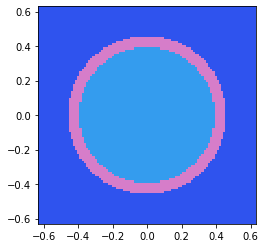

In [7]:
root_universe.plot(origin=(0., 0., 0.), width=(1.26, 1.26), pixels=(100, 100), color_by='material')

In [8]:
# Create Geometry and set root universe
geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
geometry.export_to_xml()

In [9]:
# OpenMC simulation parameters
batches = 200
inactive = 50
particles = 10000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.run_mode = 'eigenvalue'

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -10, 0.63, 0.63, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [10]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups((0.0, 0.058, 0.14, 0.28, 0.625, 4.0, 10.0, 40.0, 5530.0,
                                   0.821e6, 20.0e6))
#groups = openmc.mgxs.EnergyGroups([0., 0.625, 20.0e6])

In [11]:
# Initialize a 2-group MGXS Library for OpenMC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

In [12]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                       'nu-scatter matrix', 'multiplicity matrix', 'chi']

In [13]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = "material"

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geometry.get_all_materials().values()

In [14]:
# Do not compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = False

In [15]:
# Set the Legendre order to 3 for P3 scattering
mgxs_lib.legendre_order = 3

/home/bforget/.local/lib/python3.8/site-packages/openmc/mgxs/library.py:418: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


In [16]:
# Check the library - if no errors are raised, then the library is satisfactory.
mgxs_lib.check_library_for_openmc_mgxs()

In [17]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

In [18]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In [19]:
cell_filter = openmc.CellFilter([fuel_cell,clad_cell, moderator_cell])

energy_filter = openmc.EnergyFilter([0.0, 0.058, 0.14, 0.28, 0.625, 4.0, 10.0, 40.0, 5530.0,
                                   0.821e6, 20.0e6])

tally = openmc.Tally(name='cell tally')
tally.filters = [cell_filter, energy_filter]
tally.scores = ['flux']

# Add tally to collection
tallies_file.append(tally, merge=True)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=66.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


In [20]:
# Run OpenMC
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      130/1    1.14031    1.16275 +/- 0.00165
      131/1    1.16018    1.16272 +/- 0.00163
      132/1    1.16714    1.16277 +/- 0.00161
      133/1    1.14953    1.16261 +/- 0.00160
      134/1    1.15505    1.16252 +/- 0.00158
      135/1    1.13676    1.16222 +/- 0.00159
      136/1    1.15559    1.16214 +/- 0.00157
      137/1    1.15208    1.16203 +/- 0.00156
      138/1    1.16475    1.16206 +/- 0.00154
      139/1    1.16861    1.16213 +/- 0.00153
      140/1    1.17706    1.16230 +/- 0.00152
      141/1    1.17663    1.16246 +/- 0.00151
      142/1    1.16413    1.16247 +/- 0.00149
      143/1    1.17550    1.16261 +/- 0.00148
      144/1    1.19676    1.16298 +/- 0.00151
      145/1    1.16079    1.16295 +/- 0.00150
      146/1    1.15543    1.16288 +/- 0.00148
      147/1    1.17271    1.16298 +/- 0.00147
      148/1    1.16613    1.16301 +/- 0.00146
      149/1    1.18980    1.16328 +/- 0.00147
      150/1    1.18598    1.16351 +/- 0.00147
      151/1    1.14829    1.16336 

In [21]:
# Move the statepoint File
ce_spfile = './statepoint_ce.h5'
os.rename('statepoint.{}.h5'.format(batches), ce_spfile)
# Move the Summary file
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)

In [22]:
# Load the statepoint file
sp = openmc.StatePoint(ce_spfile, autolink=False)

# Load the summary file in its new location
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

We generate a MGXS library for all three materials used in our fuel pin.

In [23]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

In [24]:
# Create a MGXS File which can then be written to disk
mgxs_file = mgxs_lib.create_mg_library(xs_type='macro', xsdata_names=['fuel', 'zircaloy', 'water'])

# Write the file to disk using the default filename of "mgxs.h5"
mgxs_file.export_to_hdf5()

We assign the MGXS libraries to our materials.  In this case, the geometry doesn't change.  We are only doing energy condensation within each region.

In [25]:
# Re-define our materials to use the multi-group macroscopic data
# instead of the continuous-energy data.

# 1.6% enriched fuel UO2
fuel_mg = openmc.Material(name='UO2', material_id=1)
fuel_mg.add_macroscopic('fuel')

# cladding
zircaloy_mg = openmc.Material(name='Clad', material_id=2)
zircaloy_mg.add_macroscopic('zircaloy')

# moderator
water_mg = openmc.Material(name='Water', material_id=3)
water_mg.add_macroscopic('water')

# Finally, instantiate our Materials object
materials_file = openmc.Materials((fuel_mg, zircaloy_mg, water_mg))

# Set the location of the cross sections file
materials_file.cross_sections = 'mgxs.h5'

# Export to "materials.xml"
materials_file.export_to_xml()

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


We turn on multigroup mode.

In [26]:
# Set the energy mode
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

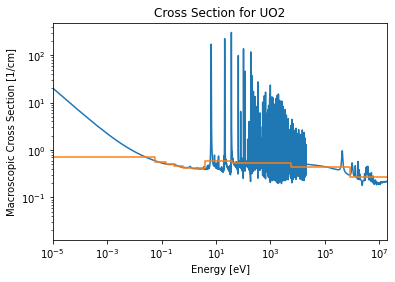

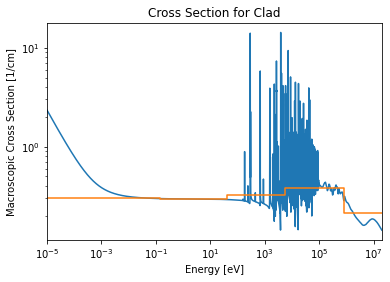

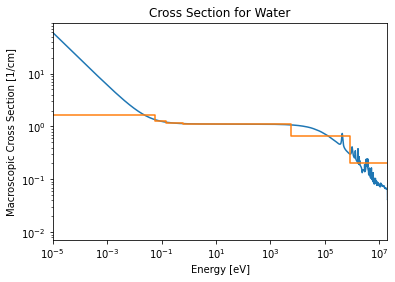

In [27]:
# First lets plot the fuel data
# We will first add the continuous-energy data
fig = openmc.plot_xs(fuel, ['total'])

# We will now add in the corresponding multi-group data and show the result
openmc.plot_xs(fuel_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

# Then repeat for the zircaloy data
fig = openmc.plot_xs(zircaloy, ['total'])
openmc.plot_xs(zircaloy_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

# And finally repeat for the water data
fig = openmc.plot_xs(water, ['total'])
openmc.plot_xs(water_mg, ['total'], plot_CE=False, mg_cross_sections='mgxs.h5', axis=fig.axes[0])
fig.axes[0].legend().set_visible(False)
plt.show()
plt.close()

In [28]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()

cell_filter = openmc.CellFilter([fuel_cell,clad_cell, moderator_cell])
energy_filter = openmc.EnergyFilter([0.0, 0.058, 0.14, 0.28, 0.625, 4.0, 10.0, 40.0, 5530.0,
                                   0.821e6, 20.0e6])

mg_tally = openmc.Tally(name='cell tally MG')
mg_tally.filters = [cell_filter, energy_filter]
mg_tally.scores = ['flux']

tallies_file.append(mg_tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

In [29]:
# Run the Multi-Group OpenMC Simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      157/1    1.15763    1.16165 +/- 0.00130
      158/1    1.14042    1.16146 +/- 0.00130
      159/1    1.18530    1.16168 +/- 0.00131
      160/1    1.16673    1.16172 +/- 0.00129
      161/1    1.14921    1.16161 +/- 0.00129
      162/1    1.16685    1.16166 +/- 0.00128
      163/1    1.17050    1.16173 +/- 0.00127
      164/1    1.15136    1.16164 +/- 0.00126
      165/1    1.16955    1.16171 +/- 0.00125
      166/1    1.16829    1.16177 +/- 0.00124
      167/1    1.15826    1.16174 +/- 0.00123
      168/1    1.18660    1.16195 +/- 0.00124
      169/1    1.16642    1.16199 +/- 0.00123
      170/1    1.16452    1.16201 +/- 0.00122
      171/1    1.16391    1.16202 +/- 0.00121
      172/1    1.14892    1.16192 +/- 0.00120
      173/1    1.15898    1.16189 +/- 0.00119
      174/1    1.15517    1.16184 +/- 0.00119
      175/1    1.16022    1.16183 +/- 0.00118
      176/1    1.16849    1.16188 +/- 0.00117
      177/1    1.16204    1.16188 +/- 0.00116
      178/1    1.16572    1.16191 

In [30]:
# Move the StatePoint File
mg_spfile = './statepoint_mg.h5'
os.rename('statepoint.' + str(batches) + '.h5', mg_spfile)
# Move the Summary file
mg_sumfile = './summary_mg.h5'
os.rename('summary.h5', mg_sumfile)

# Rename and then load the last statepoint file and keff value
mgsp = openmc.StatePoint(mg_spfile, autolink=False)

# Load the summary file in its new location
mgsu = openmc.Summary(mg_sumfile)
mgsp.link_with_summary(mgsu)

# Get keff
mg_keff = mgsp.k_combined

In [31]:
ce_keff = sp.k_combined

In [32]:
bias = 1.0E5 * (ce_keff - mg_keff)

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff))
print('Multi-Group keff = {0:1.6f}'.format(mg_keff))
print('bias [pcm]: {0:1.1f}'.format(bias.nominal_value))

Continuous-Energy keff = 1.163729+/-0.000683
Multi-Group keff = 1.161964+/-0.000510
bias [pcm]: 176.5


So what happened here?

When fully homogenizing the pin cell, we match the results exactly, but when only condensing in energy over each material, we now see statistically significant differences.

MGXS are setup to preserve reaction rates in a cell, but they do not preserve the streaming of neutrons across cells.  So as long as we have some level of heterogenity in our system (homogenized assemblies, homogenized pins or energy condensation per material), we will not reproduce the balance between neutron production and losses because we cannot account for the proper transfer of neutrons between regions.

How can we fix this? 

# SPH

SPH factors is one way to fix this problem.  It is an iterative process that tries to adjust the cross-sections in order to force the scalar fluxes in each region to match that of the reference.  This way we enfore that the MGXS solution matches both the reacion rate and cell-to-cell transfer.

There are other approaches out there that rely mainly on capturing the discontinuity that is created between the reference system and the homogenized/condensed system.

In [33]:
mg_flux_tally = mgsp.get_tally(name='cell tally MG')
mg_flux = mg_flux_tally.get_values(scores=['flux'])

In [35]:
ce_flux_tally = sp.get_tally(name='cell tally')
ce_flux = ce_flux_tally.get_values(scores=['flux'])

In [36]:
sph_fuel = ce_flux[0:10]/mg_flux[0:10]

In [37]:
sph_fuel_order = np.flipud(sph_fuel)

You can create SPH factors for every cell, but to make convergence easier we most often focus only on getting the fuel pins correct. The largest corrections happen in the resolved resonance region where massive changes in cross-section occurs.  

In [38]:
sph_fuel_order

array([[[1.0023621 ]],

       [[1.00029917]],

       [[0.99442896]],

       [[0.98771061]],

       [[0.98994396]],

       [[1.00183581]],

       [[1.00441098]],

       [[1.00360926]],

       [[1.00252298]],

       [[1.00121515]]])

We now create a new MGXS library where each macro will be corrected by the SPH factor.

In [39]:
import copy

In [40]:
sph_mgxs = copy.deepcopy(mgxs_file)

In [41]:
mgxs_file.xsdatas[0].absorption[0]

array([0.01078517, 0.00621191, 0.03981136, 0.12710179, 0.20140004,
       0.02882093, 0.06819209, 0.10591862, 0.15596204, 0.31962302])

In [42]:
mgxs_file.xsdatas[0].chi

[array([7.61323692e-01, 2.38474020e-01, 2.02288390e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00])]

In [43]:
for i in range(10):
    sph_mgxs.xsdatas[0].absorption[0][i] = sph_mgxs.xsdatas[0].absorption[0][i]*sph_fuel_order[i]
    sph_mgxs.xsdatas[0].nu_fission[0][i] = sph_mgxs.xsdatas[0].nu_fission[0][i]*sph_fuel_order[i]
    sph_mgxs.xsdatas[0].total[0][i] = sph_mgxs.xsdatas[0].total[0][i]*sph_fuel_order[i]
    for j in range(10):
        sph_mgxs.xsdatas[0].scatter_matrix[0][i,j,0] = sph_mgxs.xsdatas[0].scatter_matrix[0][i,j,0]*sph_fuel_order[i]

In [44]:
sph_mgxs.xsdatas[0].absorption[0]

array([0.01081065, 0.00621377, 0.03958956, 0.12553978, 0.19937476,
       0.02887384, 0.06849288, 0.10630091, 0.15635553, 0.32001141])

In [45]:
sph_mgxs.xsdatas[0].scatter_matrix[0][9,9,0]

0.3744761601781648

In [46]:
sph_mgxs.export_to_hdf5()

In [47]:
# Re-define our materials to use the multi-group macroscopic data
# instead of the continuous-energy data.

# 1.6% enriched fuel UO2
fuel_mg = openmc.Material(name='UO2', material_id=1)
fuel_mg.add_macroscopic('fuel')

# cladding
zircaloy_mg = openmc.Material(name='Clad', material_id=2)
zircaloy_mg.add_macroscopic('zircaloy')

# moderator
water_mg = openmc.Material(name='Water', material_id=3)
water_mg.add_macroscopic('water')

# Finally, instantiate our Materials object
materials_file = openmc.Materials((fuel_mg, zircaloy_mg, water_mg))

# Set the location of the cross sections file
materials_file.cross_sections = 'mgxs.h5'

# Export to "materials.xml"
materials_file.export_to_xml()

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


In [48]:
# Run the Multi-Group OpenMC Simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      157/1    1.17426    1.16201 +/- 0.00135
      158/1    1.17311    1.16211 +/- 0.00135
      159/1    1.17143    1.16220 +/- 0.00134
      160/1    1.17125    1.16228 +/- 0.00133
      161/1    1.17921    1.16243 +/- 0.00132
      162/1    1.17066    1.16250 +/- 0.00131
      163/1    1.17189    1.16259 +/- 0.00130
      164/1    1.15913    1.16256 +/- 0.00129
      165/1    1.16866    1.16261 +/- 0.00128
      166/1    1.15092    1.16251 +/- 0.00128
      167/1    1.17890    1.16265 +/- 0.00127
      168/1    1.16559    1.16267 +/- 0.00126
      169/1    1.15362    1.16260 +/- 0.00125
      170/1    1.15575    1.16254 +/- 0.00124
      171/1    1.16199    1.16254 +/- 0.00123
      172/1    1.16792    1.16258 +/- 0.00123
      173/1    1.15989    1.16256 +/- 0.00122
      174/1    1.18542    1.16274 +/- 0.00122
      175/1    1.16062    1.16273 +/- 0.00121
      176/1    1.14964    1.16262 +/- 0.00120
      177/1    1.14155    1.16246 +/- 0.00121
      178/1    1.17674    1.16257 

In [49]:
# Move the StatePoint File
sph1_spfile = './statepoint_sph1.h5'
os.rename('statepoint.' + str(batches) + '.h5', sph1_spfile)
# Move the Summary file
sph1_sumfile = './summary_sph1.h5'
os.rename('summary.h5', sph1_sumfile)

# Rename and then load the last statepoint file and keff value
sph1sp = openmc.StatePoint(sph1_spfile, autolink=False)

# Load the summary file in its new location
sph1su = openmc.Summary(sph1_sumfile)
sph1sp.link_with_summary(sph1su)

# Get keff
sph1_keff = sph1sp.k_combined

In [50]:
bias = 1.0E5 * (ce_keff - sph1_keff)

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff))
print('Multi-Group keff = {0:1.6f}'.format(sph1_keff))
print('bias [pcm]: {0:1.1f}'.format(bias.nominal_value))

Continuous-Energy keff = 1.163729+/-0.000683
Multi-Group keff = 1.164346+/-0.000611
bias [pcm]: -61.7


This example shows a single iteration of SPH factors, but in practice you would iterate on this to further reduce the error.

Once again, we cannot apply this directly to the full system, so typically we generate cross-sections at a smaller scale (pin cell or assembly) and correct the cross-sections through the iterative SPH process, and then we use this data at the larger scale.  